In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df, equalize_len_trace
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

# Experiment: Training on Very Small Sample

## Load and Clean Data

Data is stored in csv files. A data frame is created with the values:
- Trace - Shortened trace to be used as model input (ex. 1400 points before start of breathold, 100 points after start of breathhold)
- Csv_breath_holds - Breath hold length listed in CSV file
- Data_breath_holds - Breath hold length found using the derivative of the full trace
- Full_trace - Complete breath trace data (given in CSV file)
- breathhold_idx - Indices of the full trace identified as breathhold due to the derivative being zero
- bh_start_end - Indices of the full trace where the breathhold starts and ends (based on breathhold_idx)

In [5]:
beforeBH_len = 1400
afterBH_len = 100
trace_len = beforeBH_len+afterBH_len

In [6]:
# breath_df = get_breath_df('data_sdx_', 1400, 100, True)
# breath_df.to_pickle('breath_pickle')

In [7]:
breath_df = pd.read_pickle('breath_pickle')

In [8]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]
under2 = under2.reset_index(drop=True)

In [9]:
trace_lens = [len(row) for row in under2['Trace']]

In [10]:
print('Average trace len:', np.mean(trace_lens), '\t75th Percentile:', np.percentile(trace_lens, 75), '\tMax trace len:',max(trace_lens))

Average trace len: 5751.174911292006 	75th Percentile: 6312.5 	Max trace len: 24720


**Discrepancies:** Only considering files where the breathhold length listed in the CSV files is within 2 seconds of the breathhold length identified using the derivative of the trace to avoid using innacurate breath hold indices.

# Classification 

- **Goal:** Binary classification. "Short" breathholds are in the lower quartile of breath hold lengths and "long" breatholds are in the upper quartile of breath hold lengths.
- **Encoded as:** short (0) and long (1)

In [15]:
q25 = under2['Data_breath_holds'].quantile(.25)
q75 = under2['Data_breath_holds'].quantile(.75)

In [16]:
under2 = under2[(under2['Data_breath_holds'] < q25) | (under2['Data_breath_holds'] > q75)] # only consider breathholds in upper and lower quartiles

In [17]:
under2['class'] = np.where(under2['Data_breath_holds'] < q25, 0, 1) # create encoded column: short (0), long (1)

In [18]:
short = under2[under2['class']==0]
long = under2[under2['class']==1]

In [19]:
print(long.shape, short.shape)

(955, 7) (956, 7)


# Experiment: Try Extremely Simple Case

## Case: 5 short, 5 long

In [31]:
df = under2.iloc[[29, 30, 32, 33, 35, 100, 101, 102, 103, 104]]

In [32]:
df

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end,class
132,"[0.0016, 0.0024, 0.0034, 0.0048, 0.0063, 0.008...",11.06,11.90,"[0.0016, 0.0024, 0.0034, 0.0048, 0.0063, 0.008...","[2261, 2262, 2263, 2264, 2265, 2266, 2267, 226...","(2261, 3450)",0
133,"[0.0004, 0.0007, 0.0011, 0.0016, 0.0021, 0.002...",25.53,25.38,"[0.0004, 0.0007, 0.0011, 0.0016, 0.0021, 0.002...","[2421, 2422, 2423, 2424, 2425, 2426, 2427, 242...","(2421, 4958)",0
135,"[0.0005, 0.0012, 0.0023, 0.0034, 0.0047, 0.006...",19.82,20.79,"[0.0005, 0.0012, 0.0023, 0.0034, 0.0047, 0.006...","[2227, 2228, 2229, 2230, 2231, 2232, 2233, 223...","(2227, 4305)",0
136,"[0.0023, 0.0032, 0.0044, 0.006, 0.0078, 0.0098...",4.67,4.66,"[0.0023, 0.0032, 0.0044, 0.006, 0.0078, 0.0098...","[2632, 2633, 2634, 2635, 2636, 2637, 2638, 263...","(2632, 3097)",0
139,"[0.0008, 0.0011, 0.0016, 0.0021, 0.0026, 0.003...",25.58,25.53,"[0.0008, 0.0011, 0.0016, 0.0021, 0.0026, 0.003...","[2231, 2232, 2233, 2234, 2235, 2236, 2237, 223...","(2231, 4783)",0
220,"[0.0003, 0.0007, 0.0014, 0.0022, 0.0033, 0.004...",39.76,40.91,"[0.0003, 0.0007, 0.0014, 0.0022, 0.0033, 0.004...","[2313, 2314, 2315, 2316, 2317, 2318, 2319, 232...","(2313, 6403)",1
221,"[0.0003, 0.0008, 0.0016, 0.0027, 0.0041, 0.005...",39.69,41.13,"[0.0003, 0.0008, 0.0016, 0.0027, 0.0041, 0.005...","[2310, 2311, 2312, 2313, 2314, 2315, 2316, 231...","(2310, 6422)",1
222,"[0.0036, 0.0042, 0.0053, 0.0069, 0.0089, 0.011...",39.76,40.98,"[0.0036, 0.0042, 0.0053, 0.0069, 0.0089, 0.011...","[2021, 2022, 2023, 2024, 2025, 2026, 2027, 202...","(2021, 6118)",1
223,"[0.0002, 0.0007, 0.0014, 0.0024, 0.0037, 0.005...",40.01,41.14,"[0.0002, 0.0007, 0.0014, 0.0024, 0.0037, 0.005...","[2217, 2218, 2219, 2220, 2221, 2222, 2223, 222...","(2217, 6330)",1
224,"[0.0024, 0.0049, 0.0058, 0.0069, 0.0083, 0.01,...",39.20,40.35,"[0.0024, 0.0049, 0.0058, 0.0069, 0.0083, 0.01,...","[2290, 2291, 2292, 2293, 2294, 2295, 2296, 229...","(2290, 6324)",1


# Split and Normalize Data

In [33]:
x_train = df['Trace']

In [34]:
train = []
u = np.mean([item for sublist in x_train for item in sublist])
std = np.std([item for sublist in x_train for item in sublist])
for row in x_train:
    normalized_row = []
    for x in row:
        normalized_row.append((x-u)/std)
    train.append(normalized_row)

In [35]:
x_train = train

# Equalize Lengths

In [36]:
y_train = np.array(df['class'])

In [37]:
def equalize_lengths(df, trim_len):
    equal_traces = []
    for i in range(len(df)):
        curve = df[i]
        if len(curve) > trim_len:
            start_idx = len(curve)-trim_len
            equal_traces.append(curve[start_idx:])
        elif len(curve) < trim_len:
            num_zeros = trim_len - len(curve)
            
            random_nums = (np.random.random_sample(num_zeros)-0.5)
            box_pts = 100
            box = np.ones(box_pts)/box_pts
            random_nums = np.convolve(random_nums, box, mode = 'same')
            random_nums = random_nums[:num_zeros]
            #zeros = np.zeros([1, num_zeros])[0]
            equal_traces.append(np.concatenate((random_nums, curve)))
        else:
            equal_traces.append(curve)
        
        
            
    return np.array(equal_traces)

In [38]:
x_train3 = equalize_lengths(x_train, 10000)

# Initialize Data for Model and Create DataLoader

In [71]:
#dataset
from torch.utils.data import Dataset

In [72]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = len(x)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [73]:
dataset = timeseries(x_train3,y_train)

In [74]:
print("Training Shape", dataset.x.shape, dataset.y.shape)

Training Shape torch.Size([10, 10000]) torch.Size([10])


# Define LSTM Model 

In [75]:
class round_zero_decimals(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        # this can be changed for other decimal places
        n_digits = 0                                     
        exp = torch.pow(10,torch.tensor(n_digits))
        return torch.div( torch.round( input*exp ), exp)
   
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

roundActivation = round_zero_decimals.apply 

In [76]:
class myLSTM_Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=2):
        super(myLSTM_Model,self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out_pack, (ht, ct) = self.lstm(x)
        #output = output[:,-1,:] #look at yannet's code
        output = self.linear(ht[-1])
        return output
        

model = myLSTM_Model() 

In [77]:
print(model)

myLSTM_Model(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [78]:
# Initialize History
history = []

In [79]:
# Declaring Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 15

## Training Loop

In [80]:
trace_len = len(x_train3[0])

In [81]:
for i in range(epochs):
    
    x = dataset.x
    y = dataset.y
    
    # Training Loss
    train_loss = 0.0
    train_preds = []
    model.train()
    
    # Clear the gradients
    optimizer.zero_grad()
    # Forward Pass
    roundActivation = round_zero_decimals.apply 
    ypred = model(x.view(-1,trace_len,1))
    # Find the Loss
    loss = F.binary_cross_entropy_with_logits(ypred,y.view(-1,1))   
    # Calculate gradients
    loss.backward()       
    # Update Weights
    optimizer.step()      
    train_loss += loss.item()
    train_preds.append(ypred)
        
    print("y value:", y)
    print("predictions:", ypred.detach().numpy())

    
    if i%5 == 0:
        torch.save(model, 'lstm_bh')
        
    history.append(train_loss)
    print(f'Epoch {i+1} \t Training cross entropy loss: {train_loss}')


y value: tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
predictions: [[-0.25210422]
 [-0.23812279]
 [-0.24643004]
 [-0.25213653]
 [-0.23882571]
 [-0.25009203]
 [-0.2445447 ]
 [-0.24664605]
 [-0.24573393]
 [-0.24446644]]
Epoch 1 	 Training cross entropy loss: 0.7008829712867737
y value: tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
predictions: [[-0.24464008]
 [-0.23230582]
 [-0.23938887]
 [-0.24466923]
 [-0.23282667]
 [-0.24275024]
 [-0.23765716]
 [-0.2395618 ]
 [-0.23873249]
 [-0.23758598]]
Epoch 2 	 Training cross entropy loss: 0.700395941734314
y value: tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
predictions: [[-0.23723754]
 [-0.22652875]
 [-0.23240232]
 [-0.23726362]
 [-0.22686912]
 [-0.23546791]
 [-0.23082167]
 [-0.23253256]
 [-0.23178482]
 [-0.23075743]]
Epoch 3 	 Training cross entropy loss: 0.6999244689941406
y value: tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])
predictions: [[-0.22989368]
 [-0.22078818]
 [-0.22546825]
 [-0.22991669]
 [-0.22095007]
 [-0.2282423 ]


In [82]:
torch.save(model, 'lstm_bh')

## Plot Loss

(0.0, 1.0)

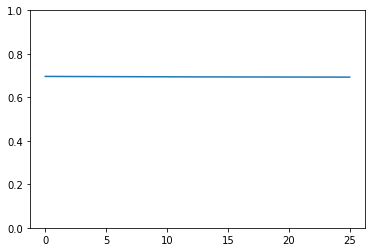

In [70]:
plt.plot(history)
plt.ylim([0,1])